## Ploting results from feature compression datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle

In [19]:
files_df = {}

for i in os.listdir('embeddings/DMS9'):
    s = os.listdir(f'embeddings/DMS9/{i}')
    files_df[i] = len(s)

pd.DataFrame.from_dict(files_df, orient='index').reset_index().rename(columns={'index':'Dataset', 0:'#files'}).sort_values('Dataset')

,Dataset,#files
9,BLAT_ECOLX_Ranganathan2015_esm2_150M,4996
24,BLAT_ECOLX_Ranganathan2015_esm2_15B,4996
0,BLAT_ECOLX_Ranganathan2015_esm2_650M,4996
26,DLG4_RAT_Ranganathan2012_esm2_150M,1659
23,DLG4_RAT_Ranganathan2012_esm2_15B,1659
18,DLG4_RAT_Ranganathan2012_esm2_650M,1659
17,IF1_ECOLI_esm2_150M,1439
21,IF1_ECOLI_esm2_15B,1439
22,IF1_ECOLI_esm2_650M,1439
10,PABP_YEAST_Fields2013_doubles_esm2_150M,36521


In [7]:
embed = pd.read_pickle('embeddings/HIS7_compressed/HIS7_esm2_150M_mean.pkl')
print(embed.shape)
embed.head()

(496137, 641)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
0,HIS7_YEAST_315835,-0.155543,-0.001378,0.011316,-0.054642,0.081170,0.080891,0.036988,-0.080311,-0.003836,...,-0.031398,-0.115347,-0.402717,0.016079,-0.112223,0.011303,-0.095164,-0.003643,-0.184110,-0.052358
1,HIS7_YEAST_390685,-0.153742,0.008390,0.007661,-0.037736,0.047987,0.084903,0.031307,-0.079463,-0.005297,...,-0.025819,-0.116625,-0.410360,0.014667,-0.105246,0.016425,-0.078078,-0.004254,-0.184573,-0.059033
2,HIS7_YEAST_324209,-0.160240,0.002693,-0.006835,-0.045952,0.066094,0.082156,0.032419,-0.085793,-0.005723,...,-0.023803,-0.109018,-0.399115,-0.002590,-0.121626,0.011350,-0.088656,-0.003923,-0.180800,-0.041902
3,HIS7_YEAST_167759,-0.159427,0.012364,0.016549,-0.050081,0.076912,0.087786,0.022870,-0.090178,0.003722,...,-0.021471,-0.096458,-0.377291,0.034713,-0.110156,0.013263,-0.092327,0.004515,-0.182487,-0.053771
4,HIS7_YEAST_102092,-0.170423,-0.015183,0.022487,-0.067134,0.104415,0.090297,0.035312,-0.080760,-0.003986,...,-0.018363,-0.107169,-0.375497,0.031552,-0.130450,0.004513,-0.102950,0.001648,-0.178366,-0.057600


In [9]:
embed[~embed['Unnamed: 0'].str.contains('HIS7')]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639


In [6]:
embed.to_pickle('embeddings/HIS7_compressed/HIS7_esm2__mean.pkl')

# FULL Pipeline

In [ ]:
# Once we have all the fasta files and metadata we can extract the embeddings for each fasta.
python scripts/extract.py esm2_t30_150M_UR50D data/sumo1_human_data.fasta embeddings/sumo1_esm2_150M --repr_layers 30 --include bos mean per_tok


# Then we can compress the embeddings with the following command
dir_path = 'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M/'
for i in ['mean', 'bos', 'max_pool', 'pca1', 'pca2', 'pca1-2', 'iDCT', 'rbf1', 'sigmoid1']:
    print(f'Compressing embeddings using {i}')
    embed = load_per_tok_embeds(dir_path, i)
    with open(f'embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed/BLAT_ECOLX_Ostermeier2014_esm2_150M_{i}.pkl', 'wb') as f:
        pickle.dump(embed, f)


# or one by one, but will take too long
python scripts/compressing_embeddings_v02.py  -e embeddings/sumo1_esm2_150M -c mean -l 30


# or by using the following command, see the script for more details
bash run_compression.sh


# with the compressed embedding we can run the regression model, see script for more details
python scripts/run_reg_Lasso.py -i embeddings/BLAT_ECOLX_Ostermeier2014_esm2_150M_compressed -m data/BLAT_ECOLX_Ostermeier2014_metadata_v02.csv -o results/BLAT_ECOLX_Ostermeier2014_esm2_150M_layer_30_compressed.csv

In [ ]:
# checking corrupted files
path_compressed_embeds = 'embeddings/PABP_YEAST_Fields2013_doubles_esm2_150M_compressed'
for file in os.listdir(path_compressed_embeds):
    if file.endswith('.pkl'):
        method = file.split('_')[-1].split('.')[0]
        print('\nResults for method:', method)
        file_path = os.path.join(path_compressed_embeds, file)
        embed = pd.read_pickle(file_path)
        embed_df = pd.DataFrame.from_dict(embed, orient='index').reset_index()
        embed_df.rename(columns={'index': 'ID'}, inplace=True)

In [10]:
data = pd.read_csv('embeddings/HIS7_YEAST_Kondrashov2017_esm2_150M_mean.csv')
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
data

,ID,0,1,2,3,4,5,6,7,8,...,630,631,632,633,634,635,636,637,638,639
0,HIS7_YEAST_126925,0.038028,-0.076741,-0.029053,0.107114,-0.078336,0.171792,-0.026830,-0.202369,0.023359,...,-0.059304,0.212200,-0.208392,0.005347,-0.248551,-0.043598,-0.025043,-0.112184,0.094114,0.068845
1,HIS7_YEAST_241091,-0.012612,-0.133964,0.009021,0.084151,-0.228388,0.146069,-0.031265,-0.205365,-0.119751,...,-0.110230,0.155723,-0.236053,-0.086100,-0.323603,0.006929,0.049817,-0.054790,0.068872,0.113053
2,HIS7_YEAST_26521,-0.035846,-0.124164,-0.041274,0.114942,-0.140980,0.184322,-0.071248,-0.239814,-0.043943,...,-0.096234,0.169712,-0.195588,-0.022760,-0.276365,-0.015466,0.001561,-0.046342,0.121312,0.047246
3,HIS7_YEAST_121046,0.047850,-0.157498,0.002093,0.108116,-0.122620,0.120660,-0.087571,-0.249543,-0.073674,...,-0.082795,0.141518,-0.138417,-0.012446,-0.296908,-0.001739,0.010201,-0.095804,0.063690,0.042536
4,HIS7_YEAST_359733,-0.038245,-0.117610,0.041429,0.143043,-0.218295,0.226004,-0.021092,-0.192766,-0.039992,...,-0.017337,0.151701,-0.168309,-0.038934,-0.252278,-0.012445,-0.056995,0.009283,0.046085,0.014138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496132,HIS7_YEAST_329930,0.028355,-0.098158,0.030384,0.125299,-0.145026,0.137920,-0.089171,-0.181958,-0.002028,...,-0.045259,0.164377,-0.129689,-0.094225,-0.266189,-0.047846,-0.009131,-0.077281,0.045884,0.073398
496133,HIS7_YEAST_361548,-0.036328,-0.136021,0.000429,0.063031,-0.186649,0.054505,-0.082425,-0.170931,-0.045187,...,-0.031661,0.198358,-0.144078,-0.067055,-0.319429,0.017289,0.018075,-0.056785,0.057655,0.052681
496134,HIS7_YEAST_236460,0.001263,-0.150735,-0.011317,0.091555,-0.237282,0.136531,-0.073528,-0.154593,-0.051814,...,-0.085946,0.146486,-0.342641,-0.056121,-0.311519,-0.016286,-0.002540,-0.019461,0.082032,0.101438
496135,HIS7_YEAST_51241,-0.016628,-0.220258,-0.016563,0.090606,-0.250055,0.144638,-0.067209,-0.151949,-0.013658,...,-0.087501,0.081613,-0.240431,-0.146416,-0.317473,-0.028322,0.044522,-0.023540,0.028588,0.067205


In [2]:
meta_data = pd.read_csv('data/metadata_DMS/HIS7_YEAST_Kondrashov2017_metadata.csv', index_col=0)
meta_data

,ID,mutant,target,sequence
0,HIS7_YEAST_1,S136C:N137D:V143I:E144N:I160V:P161T:F163V,0.755495,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
1,HIS7_YEAST_2,S136C:N137S:P139A:Y140F:A141S:V143I:E144D:I160...,0.475935,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
2,HIS7_YEAST_3,S136F:N137D:P139A:Y140F:V143I:E144N:I160V:F163V,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
3,HIS7_YEAST_4,S136F:N137D:P139A:V142F:V143T:E144N:C157S:I160...,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
4,HIS7_YEAST_5,S136F:N137D:P139A:A141C:E144D:I160V:F163I,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
...,...,...,...,...
496132,HIS7_YEAST_496133,A6V:L7S:K9R:A20S:I21L:S22C:L23I,0.970580,MTEQKVSVRRITNETKIQISLCIKGGPLAIEHSIFPEKEAEAVAEQ...
496133,HIS7_YEAST_496134,A6V:L7S:K9R:I11N:S22G:K24N,0.893046,MTEQKVSVRRNTNETKIQIAIGLNGGPLAIEHSIFPEKEAEAVAEQ...
496134,HIS7_YEAST_496135,A6V:L7S:K9R:I11N:I19V:I21L,1.159665,MTEQKVSVRRNTNETKIQVALSLKGGPLAIEHSIFPEKEAEAVAEQ...
496135,HIS7_YEAST_496136,A6V:L7S:K9S:I11D:A20S:I21L:S22G:K24N,0.876360,MTEQKVSVSRDTNETKIQISLGLNGGPLAIEHSIFPEKEAEAVAEQ...


In [5]:
len(meta_data.sequence[0])

220

1 28


<Axes: ylabel='Frequency'>

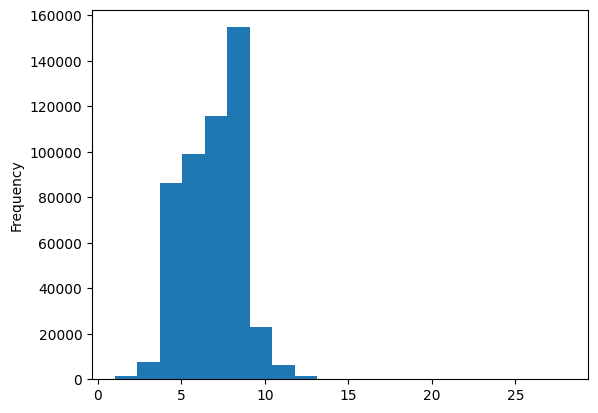

In [18]:
meta_data['Num_mutantios'] = meta_data['mutant'].apply(lambda x: len(x.split(':')))

print(meta_data['Num_mutantios'].min(), meta_data['Num_mutantios'].max())
meta_data['Num_mutantios'].plot(kind='hist', bins=20)

## Results

In [2]:
def plot_results(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='R2_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('R2 Score')
    plt.xlabel('Compression methd')
    plt.show()

In [4]:
def plot_results2(res_path):
    results = pd.read_csv(res_path, index_col=0)
    results.sort_values('Compression_methd', inplace=True)
    title = ' '.join(res_path.split('/')[-1].split('_')[:-5])
    plt.figure(figsize=(8, 3))
    sns.barplot(data=results, x='Compression_methd', y='rho_score_test')
    plt.title(title)
    plt.ylim(0, 1)
    plt.ylabel('rho Score')
    plt.xlabel('Compression methd')
    plt.show()

## Results DMS

In [19]:
data = pd.read_csv('/stor/work/Wilke/luiz/DMS_iDCT/results/summary_DMS_150M_lassoCV.csv')

data = data.query("Compression_methd == 'mean'").copy()
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
30,CALM1 HUMAN,Lasso,1,0.088342,0.269512,0.339358,0.053012,0.280916,0.355330,0.283209,0.227340,34,mean
31,CALM1 HUMAN,Lasso,2,0.093685,0.261467,0.331649,0.035367,0.300913,0.382278,0.298341,0.199859,33,mean
32,CALM1 HUMAN,Lasso,3,0.096740,0.272773,0.343829,0.013593,0.271419,0.335491,0.294732,0.146841,37,mean
33,CALM1 HUMAN,Lasso,4,0.109630,0.271159,0.341656,0.010183,0.265148,0.335314,0.316824,0.148861,43,mean
34,CALM1 HUMAN,Lasso,5,0.074047,0.274657,0.345345,0.079287,0.261989,0.336908,0.268399,0.281219,29,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,BG505 env,Lasso,1,0.195423,1.690128,1.997809,0.193891,1.676652,1.988286,0.438204,0.425944,48,mean
2761,BG505 env,Lasso,2,0.265533,1.600250,1.908926,0.243156,1.614411,1.924897,0.510933,0.489611,106,mean
2762,BG505 env,Lasso,3,0.200257,1.684886,1.992114,0.168541,1.696273,2.018000,0.443502,0.398482,44,mean
2763,BG505 env,Lasso,4,0.197833,1.680547,1.991473,0.190019,1.700746,2.005311,0.437501,0.429422,45,mean


In [20]:
cols = ['Dataset', 'R2_score_test', 'rho_score_test']
dataset_order = data[cols].groupby('Dataset').mean().sort_values('rho_score_test', ascending=False).index
data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
data.sort_values('Dataset', inplace=True)
data

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
2374,PABP doubles,Lasso,5,0.758130,0.150031,0.192816,0.749241,0.152444,0.195076,0.899111,0.892414,471,mean
2370,PABP doubles,Lasso,1,0.758891,0.149933,0.192376,0.745393,0.152281,0.197139,0.899615,0.892320,475,mean
2371,PABP doubles,Lasso,2,0.758003,0.149781,0.192388,0.749449,0.153128,0.196894,0.899582,0.892236,468,mean
2372,PABP doubles,Lasso,3,0.756899,0.150443,0.192600,0.753207,0.150812,0.196356,0.898668,0.899595,469,mean
2373,PABP doubles,Lasso,4,0.758308,0.149768,0.192841,0.748281,0.153501,0.195036,0.898028,0.898834,483,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,CALM1 HUMAN,Lasso,2,0.093685,0.261467,0.331649,0.035367,0.300913,0.382278,0.298341,0.199859,33,mean
34,CALM1 HUMAN,Lasso,5,0.074047,0.274657,0.345345,0.079287,0.261989,0.336908,0.268399,0.281219,29,mean
33,CALM1 HUMAN,Lasso,4,0.109630,0.271159,0.341656,0.010183,0.265148,0.335314,0.316824,0.148861,43,mean
32,CALM1 HUMAN,Lasso,3,0.096740,0.272773,0.343829,0.013593,0.271419,0.335491,0.294732,0.146841,37,mean


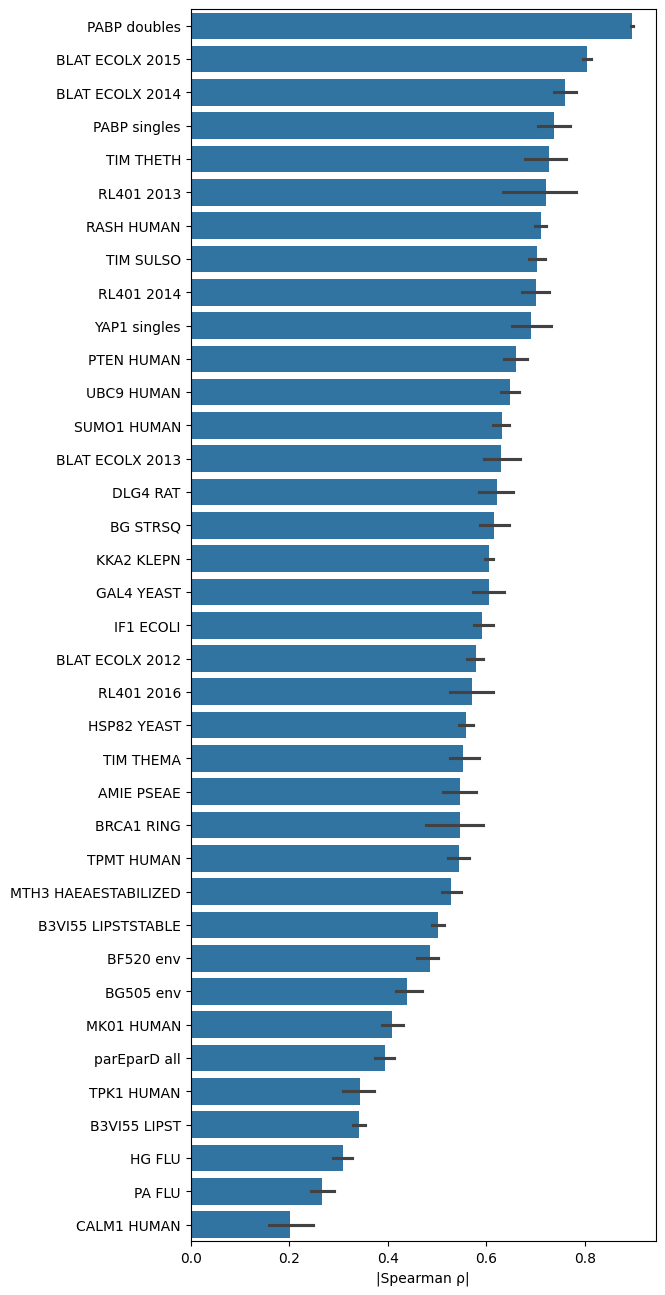

In [23]:
plt.figure(figsize=(6, 16))
sns.barplot(data=data, y='Dataset', x='rho_score_test')
plt.ylabel('rho_score_test')
plt.ylabel('')
plt.xlabel('|Spearman ρ|')
plt.savefig('results/summary_DMS_150M_spearman.png', dpi=600, bbox_inches='tight')
plt.show()

In [8]:
del_data = ['POLG_HCVJF_Sun2014', 'BRCA1_HUMAN_BRCT','UBE4B_MOUSE_Klevit2013_singles']
data['Dataset'] = data['Dataset'].astype('object')
data_plot = data[~data['Dataset'].isin(del_data)].copy()
data_plot

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd
479,PABP_YEAST_Fields2013_doubles,Lasso,10,0.631293,0.189169,0.238089,0.628551,0.188431,0.235669,0.828631,0.821527,146,maxPool
529,PABP_YEAST_Fields2013_doubles,Lasso,10,0.592134,0.199608,0.250414,0.584717,0.199911,0.249186,0.802102,0.791046,122,rbf1
528,PABP_YEAST_Fields2013_doubles,Lasso,9,0.590827,0.199695,0.250410,0.598496,0.199154,0.248654,0.801069,0.805510,123,rbf1
527,PABP_YEAST_Fields2013_doubles,Lasso,8,0.592399,0.199505,0.250149,0.585803,0.199849,0.250463,0.801240,0.802664,120,rbf1
526,PABP_YEAST_Fields2013_doubles,Lasso,7,0.591408,0.199814,0.250527,0.592822,0.197768,0.247750,0.801271,0.800164,121,rbf1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,CALM1_HUMAN_Roth2017,Lasso,4,0.264532,0.235876,0.303687,0.043707,0.285867,0.375443,0.488420,0.247820,170,maxPool
820,CALM1_HUMAN_Roth2017,Lasso,1,0.195614,0.250256,0.321220,0.061117,0.265632,0.339460,0.422231,0.251132,126,mean
818,CALM1_HUMAN_Roth2017,Lasso,9,0.246735,0.245042,0.311591,0.170108,0.238354,0.311951,0.481654,0.348144,178,sigmoid2
819,CALM1_HUMAN_Roth2017,Lasso,10,0.250865,0.241806,0.309079,0.081197,0.265002,0.344329,0.486776,0.303512,173,sigmoid2


In [4]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI']

name_map = dict(zip(old_names, new_names))
name_map

{'HG_FLU_Bloom2016': 'HG FLU',
 'BLAT_ECOLX_Ostermeier2014': 'BLAT ECOLX 2014',
 'RL401_YEAST_Bolon2014': 'RL401 2014',
 'PABP_YEAST_Fields2013_doubles': 'PABP doubles',
 'B3VI55_LIPST_Whitehead2015': 'B3VI55 LIPST',
 'TIM_THETH': 'TIM THETH',
 'CALM1_HUMAN_Roth2017': 'CALM1 HUMAN',
 'parEparD_Laub2015_all': 'parEparD all',
 'BF520_env_Bloom2018': 'BF520 env',
 'UBC9_HUMAN_Roth2017': 'UBC9 HUMAN',
 'DLG4_RAT_Ranganathan2012': 'DLG4 RAT',
 'BRCA1_HUMAN_RING': 'BRCA1 RING',
 'TPMT_HUMAN_Fowler2018': 'TPMT HUMAN',
 'MTH3_HAEAESTABILIZED_Tawfik2015': 'MTH3 HAEAESTABILIZED',
 'HSP82_YEAST_Bolon2016': 'HSP82 YEAST',
 'MK01_HUMAN_Johannessen': 'MK01 HUMAN',
 'PTEN_HUMAN_Fowler2018': 'PTEN HUMAN',
 'BG505_env_Bloom2018': 'BG505 env',
 'BLAT_ECOLX_Tenaillon2013': 'BLAT ECOLX 2013',
 'TIM_SULSO': 'TIM SULSO',
 'B3VI55_LIPSTSTABLE': 'B3VI55 LIPSTSTABLE',
 'RL401_YEAST_Bolon2013': 'RL401 2013',
 'PABP_YEAST_Fields2013_singles': 'PABP singles',
 'BLAT_ECOLX_Ranganathan2015': 'BLAT ECOLX 2015',
 'RL

In [11]:
dta = data_plot.drop('Model', axis=1).groupby(['Dataset', 'Compression_methd']).mean()
dta.reset_index(inplace=True)
dta.reset_index(inplace=True, drop=True)
dta

,Dataset,Compression_methd,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs
0,AMIE PSEAE,bos,5.5,0.223505,0.264636,0.334178,0.205185,0.267630,0.337704,0.493429,0.475600,57.9
1,AMIE PSEAE,iDCT,5.5,0.464497,0.212590,0.277517,0.403208,0.223169,0.292659,0.731663,0.687478,246.6
2,AMIE PSEAE,maxPool,5.5,0.380658,0.231302,0.298452,0.340511,0.237712,0.307668,0.650134,0.622094,140.2
3,AMIE PSEAE,mean,5.5,0.320527,0.239761,0.312605,0.291992,0.244672,0.318741,0.578010,0.553673,90.7
4,AMIE PSEAE,pca1,5.5,0.349872,0.239549,0.305779,0.307889,0.246401,0.315135,0.623296,0.589364,144.2
...,...,...,...,...,...,...,...,...,...,...,...,...
365,parEparD all,pca2,5.5,0.592681,0.047857,0.089921,0.582222,0.048262,0.090524,0.470023,0.467937,56.5
366,parEparD all,rbf1,5.5,0.646680,0.043030,0.083747,0.633425,0.043527,0.084737,0.458012,0.455400,78.7
367,parEparD all,rbf2,5.5,0.504987,0.051695,0.099129,0.496193,0.051956,0.099501,0.459301,0.458865,39.8
368,parEparD all,sigmoid1,5.5,0.646152,0.043094,0.083809,0.632742,0.043606,0.084811,0.459335,0.456679,77.4


# Multi Model Results on Pisces dataset

In [18]:
# metadata sample sizes
not_list = ['metadata_pisces_SS.csv', 'metadata_pisces_PCP.csv', 'metadata_pisces_EC_number.csv']
for i in os.listdir('data/metadata_pisces/'):
    if i.endswith('.csv') and i not in not_list:
        name = i.split('metadata_pisces_')[1].split('.csv')[0]  
        df = pd.read_csv(f'data/metadata_pisces/{i}')
        print(name, df.shape[0])

PCP_Hydrophobicity 24023
SS_E 24021
PCP_mW_kDa 24023
PCP_Charge 24023
SS_Coil 24021
PCP_Isoelectric_point 24023
PCP_AAfreq_Cys 24023
PCP_Instability_index 24023
PCP_AAfreq_Leu 24023
SS_H 22497
PCP_length 24023
PCP_AAfreq_Ala 24023


In [8]:
df = pd.DataFrame()
for file in os.listdir('results/lassoCV_pisces/'):
    if file.endswith('.csv'):
        target = file.split('_esm2_')[0]
        model = file.split('_esm2_')[1].split('_')[0]
        data = pd.read_csv(f'results/lassoCV_pisces/{file}', index_col=0)
        data['Model'] = model
        data['Dataset'] = target
        df = pd.concat([df, data])
df       

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,15B,1,0.861218,2.058055,2.917710,0.815957,2.449101,3.402250,0.940578,0.919561,2869,mean,PCP_Charge
1,15B,2,0.869095,2.030586,2.838003,0.809760,2.443952,3.438954,0.941985,0.917230,3177,mean,PCP_Charge
2,15B,3,0.865426,2.054973,2.881289,0.807507,2.431408,3.440643,0.940865,0.918743,2989,mean,PCP_Charge
3,15B,4,0.867598,2.039944,2.854631,0.811915,2.439659,3.417215,0.941514,0.917169,3140,mean,PCP_Charge
4,15B,5,0.867545,2.044620,2.869524,0.810085,2.445926,3.363256,0.941444,0.915129,3149,mean,PCP_Charge
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,150M,1,0.971307,0.004707,0.006120,0.969310,0.004859,0.006320,0.983775,0.982635,515,mean,PCP_AAfreq_Ala
1,150M,2,0.971735,0.004676,0.006071,0.967161,0.005058,0.006551,0.983935,0.981422,512,mean,PCP_AAfreq_Ala
2,150M,3,0.971172,0.004730,0.006138,0.970473,0.004732,0.006183,0.983793,0.982911,508,mean,PCP_AAfreq_Ala
3,150M,4,0.971237,0.004725,0.006129,0.970095,0.004759,0.006230,0.983568,0.983736,507,mean,PCP_AAfreq_Ala


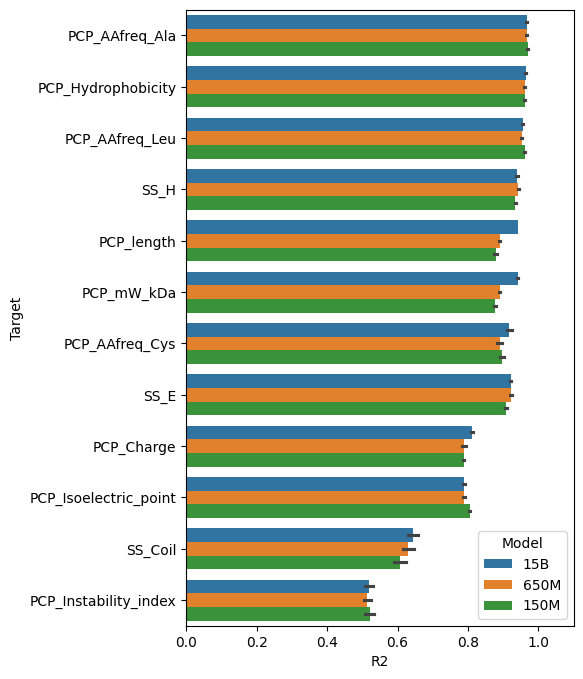

In [9]:
mean_scores = df.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)

# Get the sorted order of Datasets
sorted_datasets = mean_scores.index


# Plot the boxplot with sorted Model
plt.figure(figsize=(5, 8))
sns.barplot(data=df, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets)
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

#plt.savefig('results/lassoCV_pisces_mean_summary.png', dpi=600, bbox_inches='tight')
plt.show()

# Multi Model Results on DMS9 dataset

In [24]:
df = pd.DataFrame()
for file in os.listdir('results/lassoCV_DMS9/'):
    if file.endswith('.csv'):
        target = file.split('_esm2_')[0]
        model = file.split('_esm2_')[1].split('_')[0]
        data = pd.read_csv(f'results/lassoCV_DMS9/{file}', index_col=0)
        data['Model'] = model
        data['Dataset'] = target
        df = pd.concat([df, data])
df 

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method,Dataset
0,150M,1,0.604357,0.185047,0.258908,0.571506,0.184628,0.249809,0.722045,0.730874,83,mean,RL401_YEAST_Bolon2014
1,150M,2,0.775075,0.139150,0.194242,0.608409,0.159835,0.243687,0.773434,0.661513,190,mean,RL401_YEAST_Bolon2014
2,150M,3,0.625654,0.177377,0.249001,0.524448,0.204937,0.276760,0.729980,0.689689,88,mean,RL401_YEAST_Bolon2014
3,150M,4,0.611937,0.178466,0.248488,0.535165,0.208633,0.294808,0.730821,0.675884,85,mean,RL401_YEAST_Bolon2014
4,150M,5,0.579664,0.187125,0.260591,0.582016,0.200389,0.271566,0.714691,0.741424,79,mean,RL401_YEAST_Bolon2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,650M,1,0.361872,0.407207,0.478669,0.356228,0.433639,0.505136,0.615656,0.608920,35,mean,TIM_THETH
1,650M,2,0.374910,0.410856,0.480435,0.343961,0.409030,0.484298,0.626150,0.600788,30,mean,TIM_THETH
2,650M,3,0.392636,0.403539,0.476080,0.245562,0.430768,0.507148,0.645237,0.445796,29,mean,TIM_THETH
3,650M,4,0.349340,0.420637,0.491391,0.353172,0.409031,0.477512,0.604669,0.625267,29,mean,TIM_THETH


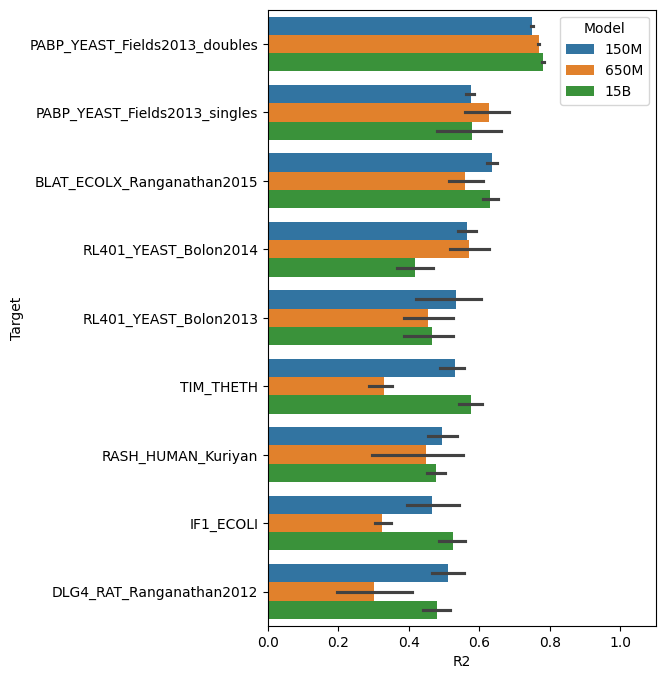

In [25]:
mean_scores = df.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)

# Get the sorted order of Datasets
sorted_datasets = mean_scores.index


# Plot the boxplot with sorted Model
plt.figure(figsize=(5, 8))
sns.barplot(data=df, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets)
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

#plt.savefig('results/lassoCV_pisces_mean_summary.png', dpi=600, bbox_inches='tight')
plt.show()

In [23]:
ress = ['esm2_150M', 'esm2_650M', 'esm2_15B']
df = pd.DataFrame()
for res in ress:
    data = pd.read_csv(f'results/summary_results_pisces_{res}_lassoCV.csv', index_col=0)    
    data['Model'] = [res] * data.shape[0]
    cols = ['Dataset', 'R2_score_test', 'rho_score_test']

    dataset_order = data[cols].groupby('Dataset').mean().sort_values('R2_score_test', ascending=False).index
    data['Dataset'] = pd.Categorical(data['Dataset'], categories=dataset_order, ordered=True)
    data.sort_values('Dataset', inplace=True)
    df = pd.concat([df, data])
   

df

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method
112,PCP_length,esm2_150M,3,0.875035,37.894600,52.135586,0.861941,39.269656,54.479620,0.948172,0.944095,578,bos
96,PCP_length,esm2_150M,2,0.907404,32.698106,45.167171,0.845404,39.671744,56.104616,0.951886,0.926049,3385,iDCT4
97,PCP_length,esm2_150M,3,0.903829,32.712860,45.736407,0.849605,40.295633,56.861486,0.951830,0.926830,3219,iDCT4
98,PCP_length,esm2_150M,4,0.906951,32.230294,44.846926,0.849858,40.814057,57.516551,0.951638,0.931766,3414,iDCT4
99,PCP_length,esm2_150M,5,0.903179,32.623849,45.472695,0.854289,39.817155,57.971348,0.951521,0.931857,3278,iDCT4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,SS_Coil,esm2_15B,4,0.005026,0.043896,0.062219,-0.001211,0.043282,0.061108,0.064868,0.024310,12,rbf2
49,SS_Coil,esm2_15B,5,0.007647,0.043501,0.061279,-0.000762,0.044551,0.064484,0.078290,0.033045,27,rbf2
50,SS_Coil,esm2_15B,1,0.008922,0.043798,0.062554,-0.000009,0.043162,0.059163,0.096445,0.047701,53,iDCT1
44,SS_Coil,esm2_15B,5,0.008208,0.043434,0.061262,0.003544,0.044448,0.064345,0.108803,0.067308,47,iDCT3


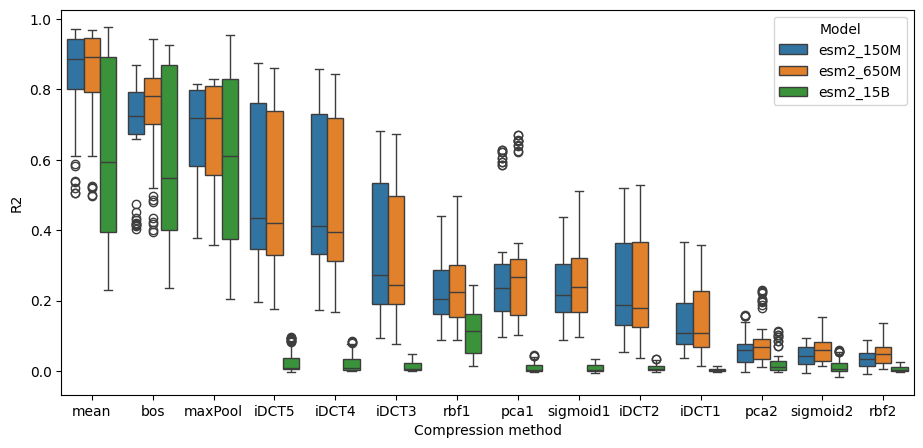

In [24]:
mean_scores = df.groupby(['Compression_method', 'Model'])['R2_score_test'].mean().reset_index()
sorted_methods = mean_scores.groupby('Compression_method')['R2_score_test'].mean().sort_values(ascending=False).index

# Plot the boxplot with sorted Compression_method
plt.figure(figsize=(11, 5))
sns.boxplot(data=df, y='R2_score_test', x='Compression_method', hue='Model', order=sorted_methods)
plt.ylabel('R2')
plt.xlabel('Compression method')
#plt.savefig('results/lassoCV_piece_res_summary.png', dpi=600, bbox_inches='tight')
plt.show()


In [25]:
df_mean = df.query('Compression_method == "mean"')
df_mean

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method
120,PCP_length,esm2_150M,1,0.887252,34.474724,49.522691,0.872754,36.183123,52.304522,0.963644,0.959935,552,mean
121,PCP_length,esm2_150M,2,0.884656,35.060247,50.410900,0.884137,34.444282,48.570454,0.963159,0.961724,554,mean
122,PCP_length,esm2_150M,3,0.884989,34.788989,50.015969,0.883444,35.304745,50.057540,0.963273,0.960689,547,mean
123,PCP_length,esm2_150M,4,0.886541,34.345335,49.521684,0.876935,36.275022,52.072646,0.963583,0.960841,545,mean
124,PCP_length,esm2_150M,5,0.886594,34.146345,49.213241,0.876272,36.118006,53.419599,0.964236,0.963072,553,mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,SS_Coil,esm2_15B,3,0.362519,0.035310,0.049077,0.235446,0.038354,0.056533,0.551889,0.490756,879,mean
30,SS_Coil,esm2_15B,1,0.351248,0.035936,0.050610,0.251362,0.037276,0.051190,0.544549,0.482929,853,mean
31,SS_Coil,esm2_15B,2,0.337842,0.036000,0.050764,0.259251,0.037628,0.052535,0.541012,0.476225,736,mean
33,SS_Coil,esm2_15B,4,0.366451,0.035547,0.049649,0.231662,0.037183,0.053532,0.553351,0.478442,881,mean


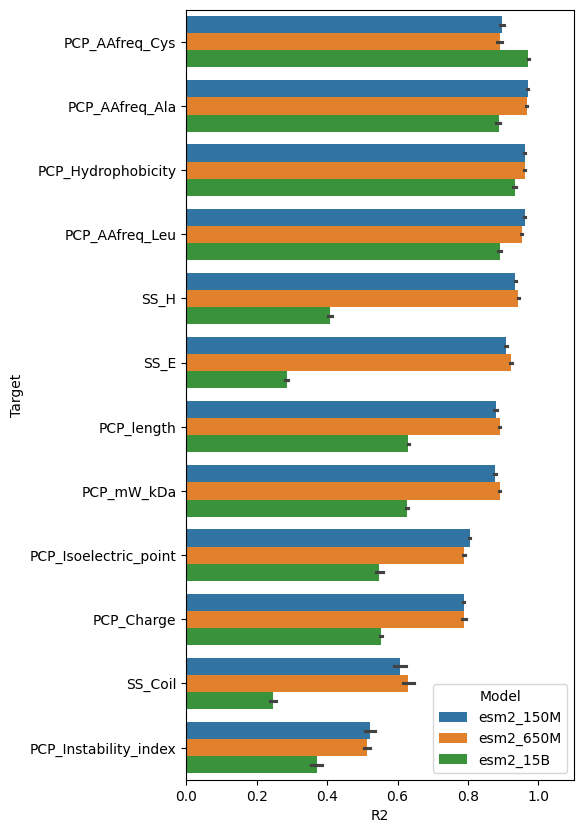

In [27]:
mean_scores = df_mean.groupby('Dataset')['R2_score_test'].max().sort_values(ascending=False)

# Get the sorted order of Datasets
sorted_datasets = mean_scores.index


# Plot the boxplot with sorted Model
plt.figure(figsize=(5, 10))
sns.barplot(data=df_mean, x='R2_score_test', y='Dataset', hue='Model', order=sorted_datasets)
plt.xlabel('R2')
plt.xlim(0, 1.1)
plt.ylabel('Target')

plt.savefig('results/lassoCV_pisces_mean_summary.png', dpi=600, bbox_inches='tight')
plt.show()

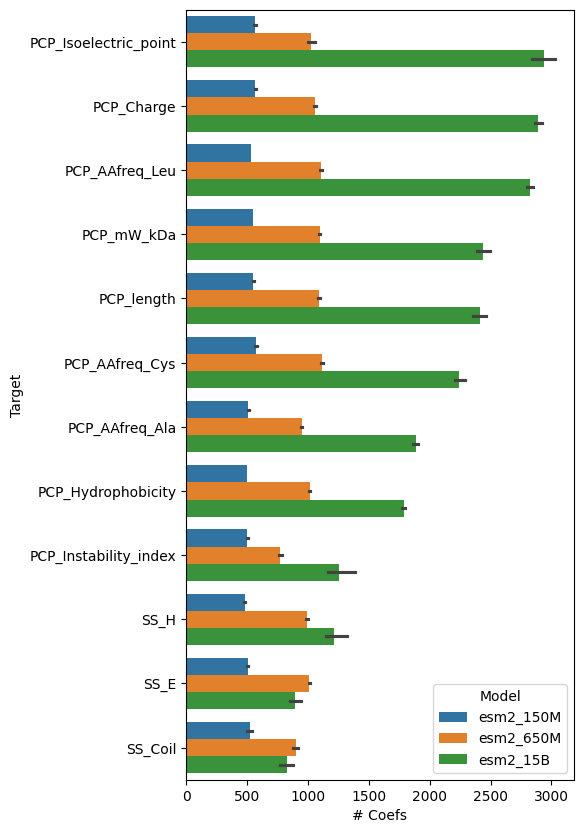

In [43]:
mean_scores = df_mean.groupby('Dataset')['nun_zero_coefs'].max().sort_values(ascending=False)

# Get the sorted order of Datasets
sorted_datasets = mean_scores.index


# Plot the boxplot with sorted Model
plt.figure(figsize=(5, 10))
sns.barplot(data=df_mean, x='nun_zero_coefs', y='Dataset', hue='Model', order=sorted_datasets)
plt.xlabel('# Coefs')
#plt.xlim(0, 1.1)
plt.ylabel('Target')

#plt.savefig('results/lassoCV_piece_res_summary.png', dpi=600, bbox_inches='tight')
plt.show()

# Sample size effect on predictions

## Hydrophobocity

In [22]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_pisces/lassoCV_sampling/lassoCV_PCP_Hydrophobicity_sampling_esm2_{model}_v02.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,0.999987,0.001058,0.001457,-0.232858,0.300086,0.459473,0.999783,0.428571,377,32
1,150M,2,0.998897,0.010465,0.013162,0.705445,0.207851,0.234327,0.998846,0.942857,29,32
2,150M,3,0.999985,0.001026,0.001568,-0.638183,0.378900,0.416229,0.999808,0.942857,380,32
3,150M,4,0.999984,0.001265,0.001762,-4.442157,0.303342,0.562415,0.999615,0.600000,454,32
4,150M,5,0.987113,0.037591,0.042112,-1.979871,0.383383,0.430598,0.995385,0.485714,25,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,0.956622,0.044507,0.060044,0.936815,0.050476,0.071370,0.974053,0.965952,1801,24023
1,15B,2,0.956977,0.044243,0.059812,0.933003,0.051359,0.073411,0.974808,0.961148,1747,24023
2,15B,3,0.956814,0.044247,0.059648,0.936838,0.051023,0.072629,0.974526,0.964442,1812,24023
3,15B,4,0.957520,0.044113,0.059104,0.925764,0.050924,0.079025,0.974705,0.964839,1766,24023


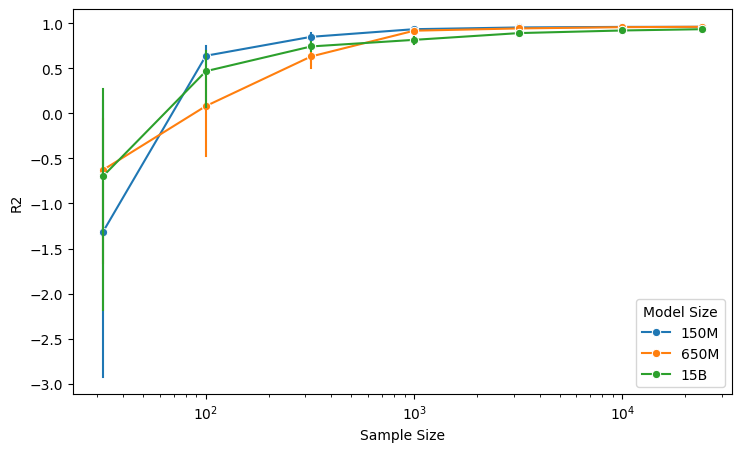

In [23]:
#plotting the results
#data = data.query('Sample_size >=100')
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars")
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
#plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_hydro_sampling_summary_v02.png', dpi=600, bbox_inches='tight')
plt.show()

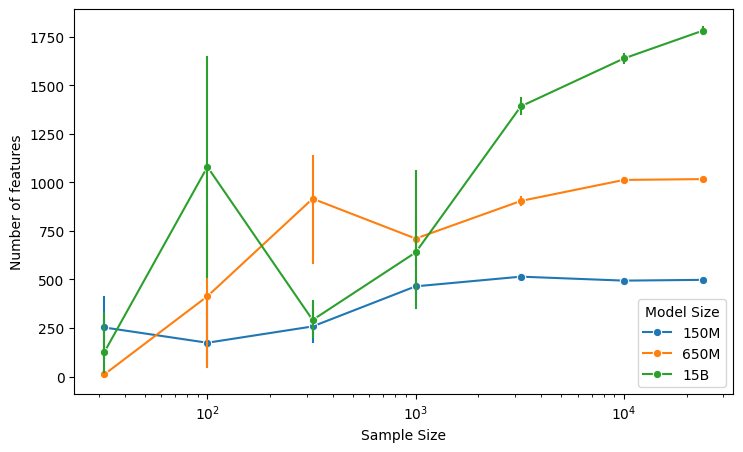

In [24]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars")
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
#plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_Hydro_sampling_num_feature_v02.png', dpi=600, bbox_inches='tight')
plt.show()

## SS Helix

In [43]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_pisces/lassoCV_sampling/lassoCV_SS_H_sampling_esm2_{model}_v02.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,0.999990,0.000356,0.000489,-0.177891,0.150308,0.208900,1.000000,0.428571,330,32
1,150M,2,0.993673,0.010775,0.013553,0.425276,0.085151,0.111933,0.990435,0.828571,24,32
2,150M,3,0.999992,0.000393,0.000498,-2.435740,0.208307,0.257778,1.000000,-0.485714,288,32
3,150M,4,0.920267,0.037895,0.046515,0.406322,0.095222,0.119256,0.956522,0.714286,13,32
4,150M,5,0.988378,0.012721,0.017906,0.198200,0.131892,0.148624,0.986087,1.000000,26,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,0.518287,0.106482,0.135789,0.389160,0.116855,0.151422,0.662452,0.574941,1259,22497
1,15B,2,0.516885,0.105946,0.135060,0.400517,0.119207,0.154124,0.661047,0.580430,1221,22497
2,15B,3,0.489950,0.108707,0.138935,0.434782,0.115975,0.148995,0.645285,0.591370,1052,22497
3,15B,4,0.505044,0.107880,0.137705,0.407607,0.114983,0.148851,0.651792,0.587116,1139,22497


In [26]:
data.to_csv('results/lassoCV_pisces/lassoCV_sampling/lassoCV_SS_H_sampling_esm2_all_v02.csv')

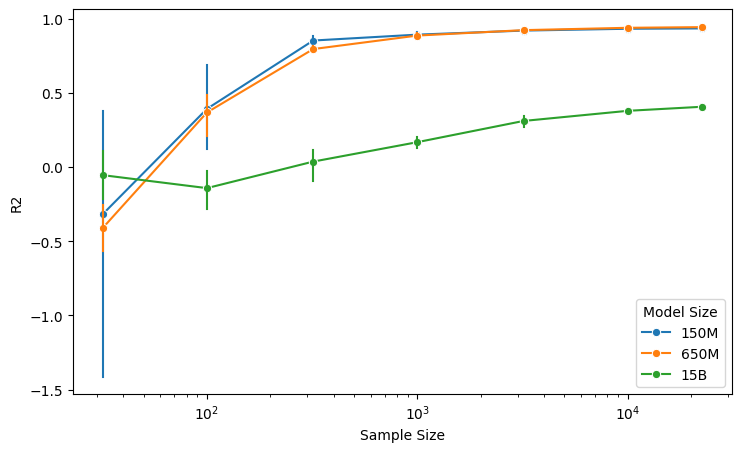

In [44]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars")
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_ssH_sampling_summary_v02.png', dpi=600, bbox_inches='tight')
plt.show()

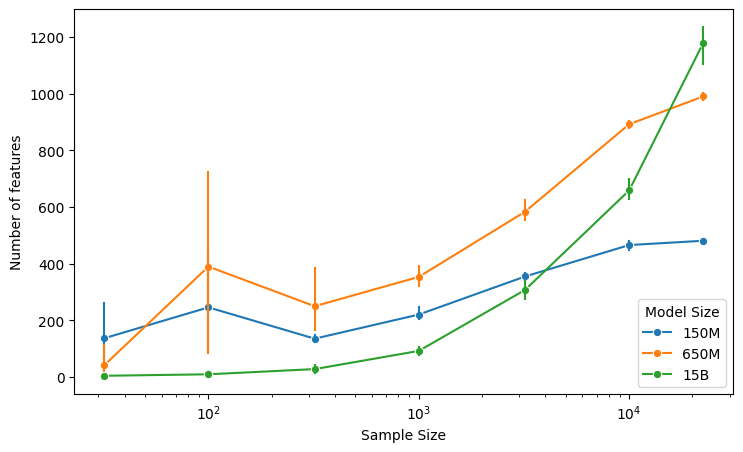

In [45]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars")
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_ssH_sampling_num_feature_v02.png', dpi=600, bbox_inches='tight')
plt.show()

## SS Coil

In [2]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_pisces/lassoCV_sampling/lassoCV_SS_Coil_sampling_esm2_{model}.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,9.999902e-01,0.000155,0.000190,-3.608572,0.073803,0.084794,1.000000,-0.028571,353,32
1,150M,2,-6.550316e-14,0.040846,0.053467,-0.173773,0.053848,0.070789,NaN,NaN,0,32
2,150M,3,9.886549e-01,0.004902,0.005817,0.013097,0.042316,0.057877,0.988696,0.542857,20,32
3,150M,4,6.920710e-01,0.027227,0.033270,-0.547080,0.039352,0.052451,0.831304,0.085714,11,32
4,150M,5,9.386649e-01,0.011670,0.013719,-0.421252,0.053084,0.069618,0.964348,0.428571,20,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,3.490514e-01,0.035758,0.049927,0.231740,0.038209,0.055270,0.540799,0.480692,786,24021
1,15B,2,3.627428e-01,0.035657,0.049772,0.263490,0.037258,0.052505,0.548693,0.494699,932,24021
2,15B,3,3.708748e-01,0.035475,0.049914,0.243902,0.037182,0.051097,0.560105,0.466244,979,24021
3,15B,4,3.480373e-01,0.035517,0.049759,0.240044,0.038662,0.055834,0.546331,0.479348,822,24021


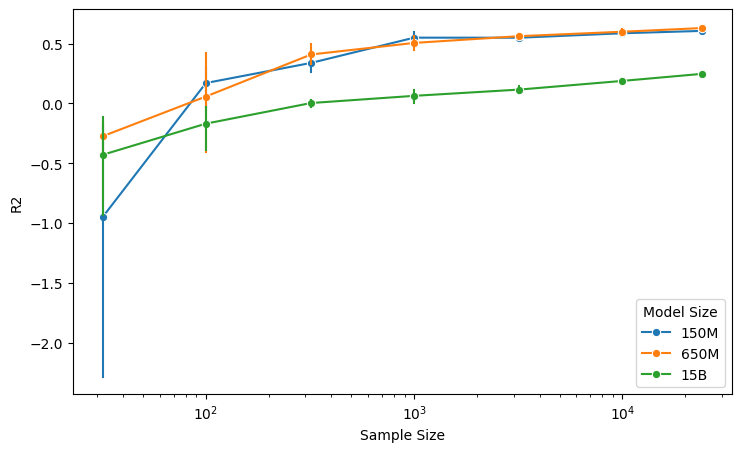

In [3]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars")
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_ssCoil_sampling_summary.png', dpi=600, bbox_inches='tight')
plt.show()

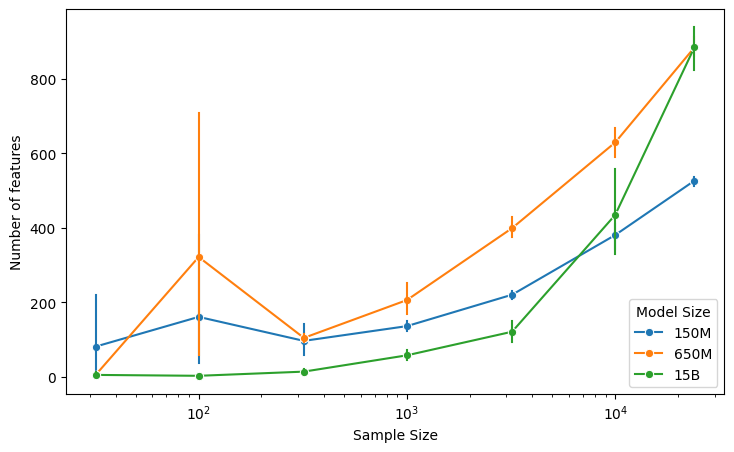

In [4]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars")
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_ssCoil_sampling_num_feature.png', dpi=600, bbox_inches='tight')
plt.show()

## AA freq Cys

In [46]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_pisces/lassoCV_sampling/lassoCV_PCP_AAfreq_Cys_sampling_esm2_{model}_v02.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,0.972984,0.002058,0.002465,0.299991,0.008436,0.010461,0.977391,0.535714,22,32
1,150M,2,0.954849,0.002439,0.003280,0.024210,0.007832,0.009839,0.975760,0.257143,14,32
2,150M,3,0.999988,0.000035,0.000052,-1.879114,0.020867,0.021148,1.000000,-0.428571,307,32
3,150M,4,0.999155,0.000378,0.000453,-2.020384,0.011309,0.012070,0.997307,0.828571,38,32
4,150M,5,0.881010,0.003014,0.003852,0.343161,0.012448,0.018214,0.958830,0.942857,14,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,0.982741,0.001574,0.002122,0.971152,0.001915,0.002872,0.975253,0.960502,2223,24023
1,15B,2,0.982499,0.001594,0.002145,0.972529,0.001897,0.002761,0.974434,0.966519,2256,24023
2,15B,3,0.982508,0.001604,0.002164,0.972612,0.001875,0.002663,0.974307,0.964140,2317,24023
3,15B,4,0.982945,0.001602,0.002157,0.969078,0.001917,0.002712,0.974502,0.963411,2289,24023


In [30]:
data.to_csv('results/lassoCV_pisces/lassoCV_sampling/lassoCV_PCP_AAfreq_Cys_sampling_esm2_all_v02.csv')

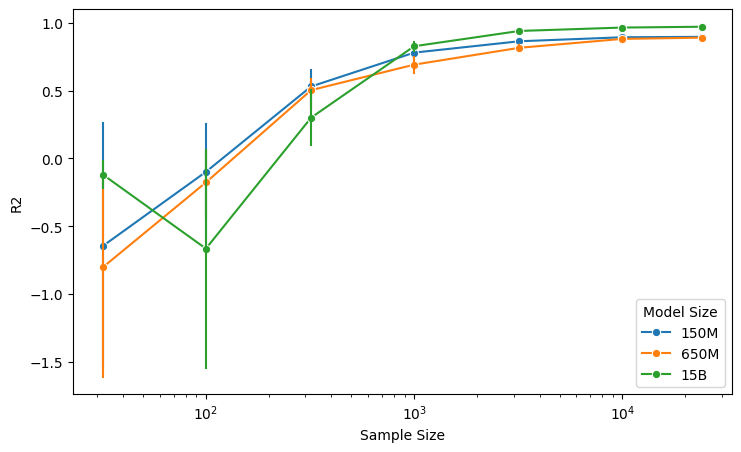

In [47]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars")
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_PCP_AAfreq_Cys_sampling_summary_v02.png', dpi=600, bbox_inches='tight')
plt.show()

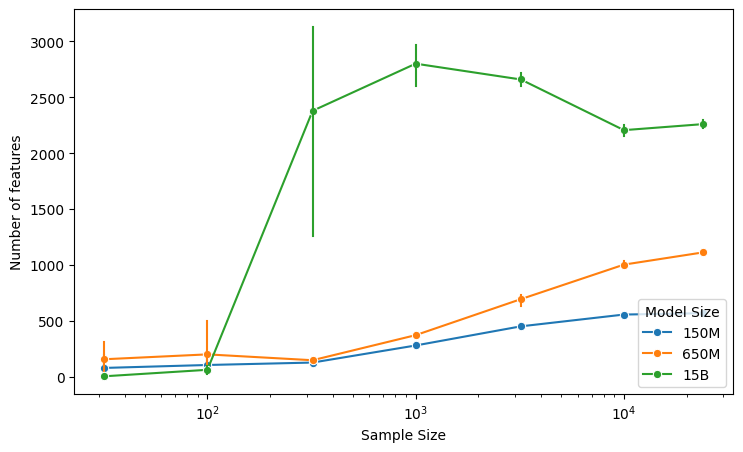

In [48]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars")
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
plt.savefig('results/lassoCV_pisces/lassoCV_sampling/lassoCV_PCP_AAfreq_Cys_sampling_num_feature_v02.png', dpi=600, bbox_inches='tight')
plt.show()

## DMS PABP_YEAST_Fields2013_doubles

In [19]:
data = pd.DataFrame()
for model in ['150M', '650M', '15B']:
    dta = pd.read_csv(f'results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_{model}.csv', index_col=0)
    dta['Model'] = [model] * dta.shape[0]
    data = pd.concat([data, dta], axis=0)

data

,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Sample_size
0,150M,1,0.338655,0.303215,0.347181,-0.372177,0.496601,0.543677,0.684333,0.197028,3,32
1,150M,2,0.000000,0.430087,0.449912,-0.045965,0.418240,0.437628,0.304390,-0.558407,1,32
2,150M,3,0.129435,0.400465,0.422057,0.024673,0.383950,0.416566,0.599433,0.463817,1,32
3,150M,4,0.566428,0.264568,0.292904,-0.418797,0.442051,0.502154,0.822158,0.085714,9,32
4,150M,5,0.040883,0.421865,0.444538,0.019421,0.386119,0.410473,0.638534,-0.086966,1,32
...,...,...,...,...,...,...,...,...,...,...,...,...
0,15B,1,0.591622,0.225489,0.287042,0.590619,0.225450,0.286870,0.728859,0.725012,2959,496137
1,15B,2,0.592418,0.225275,0.286796,0.588089,0.225842,0.287614,0.729173,0.724789,2987,496137
2,15B,3,0.592738,0.225032,0.286459,0.585383,0.226999,0.289463,0.728015,0.727866,2979,496137
3,15B,4,0.592350,0.225081,0.286584,0.588853,0.226383,0.288302,0.728485,0.727329,2986,496137


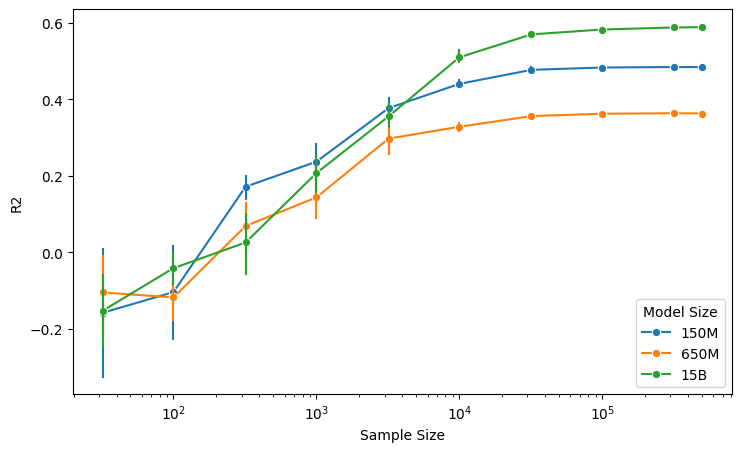

In [20]:
#plotting the results
#data = data.query('Sample_size >=100')
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='R2_score_test', hue='Model', marker='o', err_style="bars")
plt.ylabel('R2')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
#plt.savefig('results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_R2.png', dpi=600, bbox_inches='tight')
plt.show()

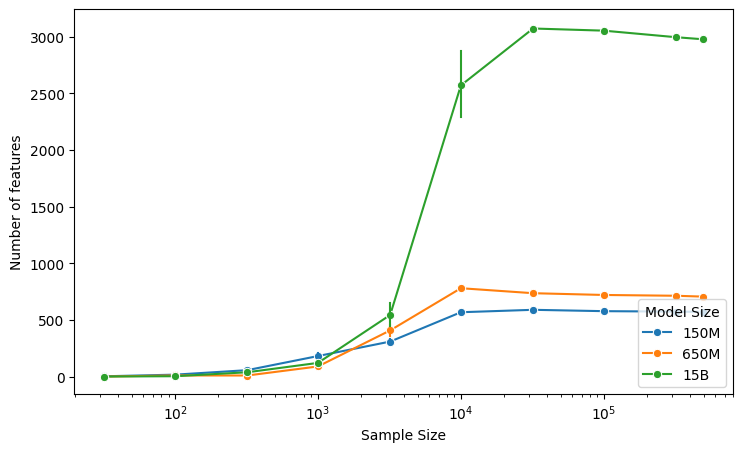

In [21]:
#plotting the results
plt.figure(figsize=(8.5, 5)) 
sns.lineplot(data=data, x='Sample_size', y='nun_zero_coefs', hue='Model', marker='o', err_style="bars")
plt.ylabel('Number of features')
plt.xlabel('Sample Size')
plt.legend(title='Model Size', loc='lower right')
plt.xscale('log')
#plt.savefig('results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_all_num_feature.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#data.to_csv('results/lassoCV_DMS/lassoCV_sampling/HIS7_YEAST_Kondrashov2017_sampling_esm2_all.csv')

In [33]:
stop

NameError: name 'stop' is not defined

## Results lassoCV

In [6]:
base_path = 'results/lassoCV'
data = pd.DataFrame()
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path, index_col=0)
    dataset = [file.split('_esm2')[0]] *len(df)

    df.insert(0, 'Dataset', dataset,)
    data = pd.concat([data, df])

data.reset_index(drop=True, inplace=True)
data = data.query("Compression_method != 'iDCT'")
data.to_csv('results/summary_DMS_results_lassoCV.csv')

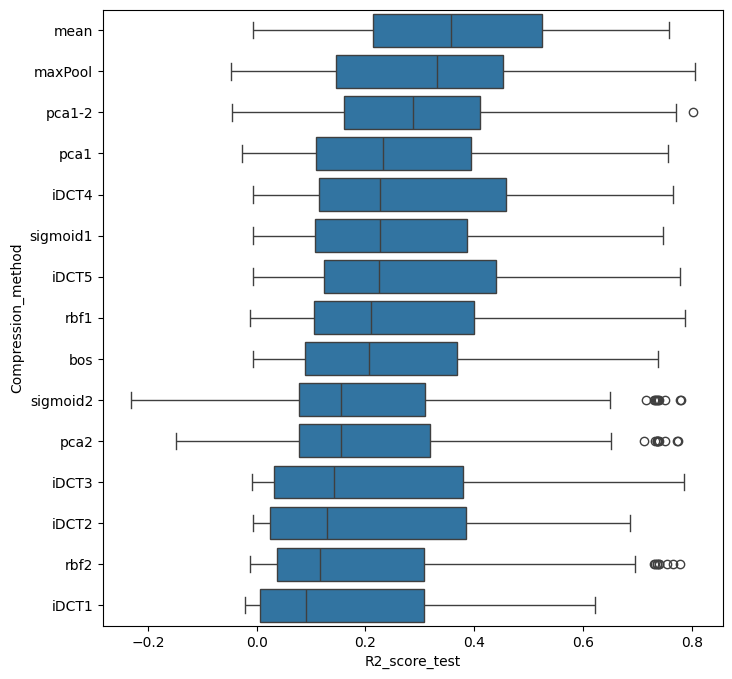

In [5]:
median_r2 = data.groupby('Compression_method')['R2_score_test'].median().sort_values(ascending=False)

sorted_methods = median_r2.index

plt.figure(figsize=(8, 8))
sns.boxplot(data=data, y='Compression_method', x='R2_score_test', order=sorted_methods)
plt.show()

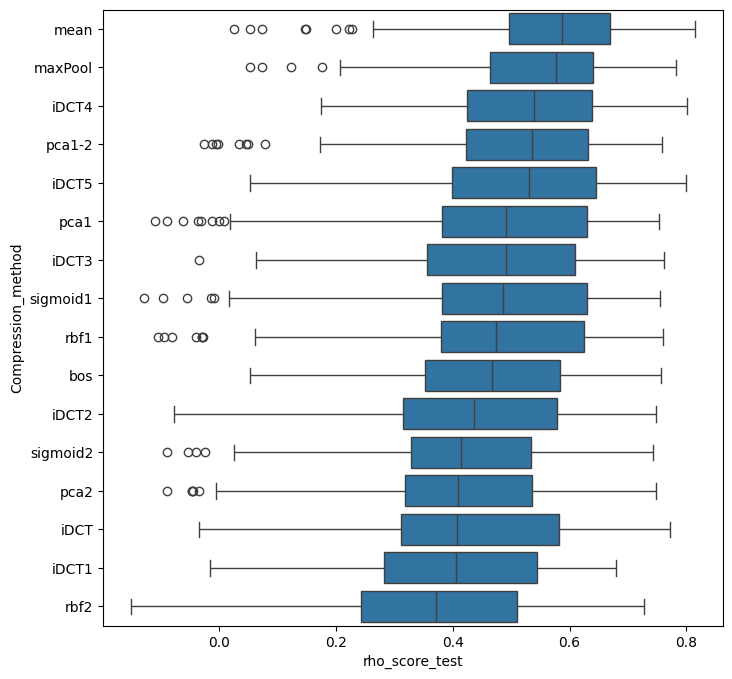

In [5]:
median_rho = data.groupby('Compression_method')['rho_score_test'].median().sort_values(ascending=False)

sorted_methods = median_rho.index

plt.figure(figsize=(8, 8))
sns.boxplot(data=data, y='Compression_method', x='rho_score_test', order=sorted_methods)
plt.show()

In [71]:
data_filter = data[['Dataset', 'Fold', 'Compression_method', 'R2_score_train', 'R2_score_test', 'rho_score_train', 'rho_score_test']]

data_melted = data_filter.melt(
    id_vars=['Dataset', 'Fold', 'Compression_method'], 
    value_vars=['R2_score_train', 'R2_score_test', 'rho_score_train', 'rho_score_test'],
    value_name='score',
    var_name='Score_type',
    )

data_melted

,Dataset,Fold,Compression_method,Score_type,score
0,POLG_HCVJF_Sun2014,1,iDCT,R2_score_train,0.000000
1,POLG_HCVJF_Sun2014,2,iDCT,R2_score_train,0.000000
2,POLG_HCVJF_Sun2014,3,iDCT,R2_score_train,0.000000
3,POLG_HCVJF_Sun2014,4,iDCT,R2_score_train,0.000000
4,POLG_HCVJF_Sun2014,5,iDCT,R2_score_train,0.000000
...,...,...,...,...,...
5115,RL401_YEAST_Bolon2014,1,mean,rho_score_test,0.730874
5116,RL401_YEAST_Bolon2014,2,mean,rho_score_test,0.661513
5117,RL401_YEAST_Bolon2014,3,mean,rho_score_test,0.689741
5118,RL401_YEAST_Bolon2014,4,mean,rho_score_test,0.675884


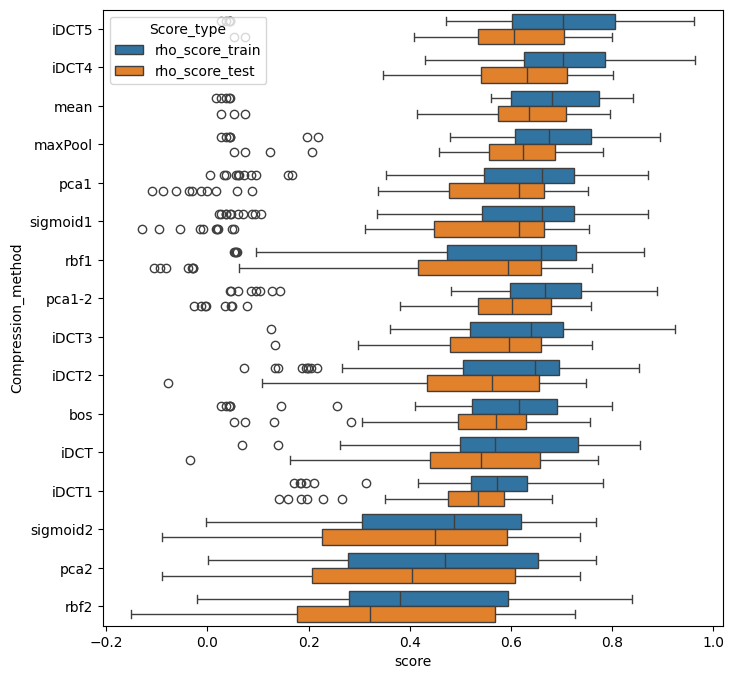

In [72]:
data_rho = data_melted[data_melted['Score_type'].str.contains('rho')]
median_rho = data_rho.groupby('Compression_method')['score'].median().sort_values(ascending=False)

rho_sorted_methods = median_rho.index

plt.figure(figsize=(8, 8))
sns.boxplot(data=data_rho, y='Compression_method', x='score', hue='Score_type', order=rho_sorted_methods)
plt.show()

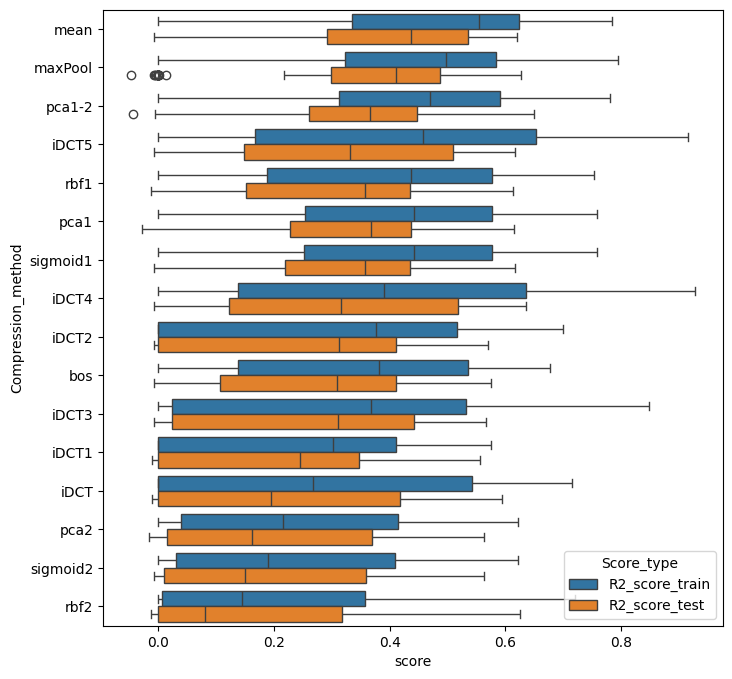

In [73]:
data_r2 = data_melted[data_melted['Score_type'].str.contains('R2')]
median_r2 = data_r2.groupby('Compression_method')['score'].median().sort_values(ascending=False)

r2_sorted_methods = median_r2.index

plt.figure(figsize=(8, 8))
sns.boxplot(data=data_r2, y='Compression_method', x='score', hue='Score_type', order=r2_sorted_methods)
plt.show()

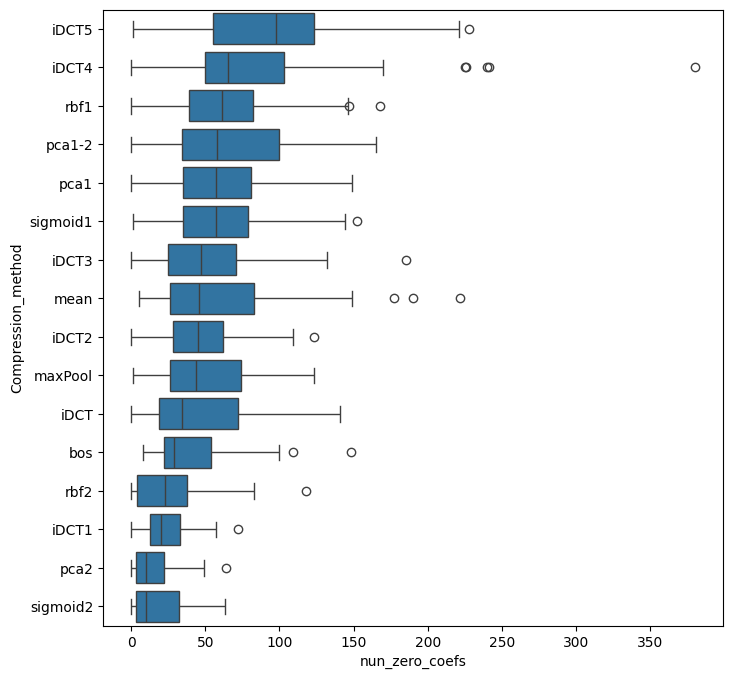

In [58]:
median_rho = data.groupby('Compression_method')['nun_zero_coefs'].median().sort_values(ascending=False)

sorted_methods = median_rho.index

plt.figure(figsize=(8, 8))
sns.boxplot(data=data, y='Compression_method', x='nun_zero_coefs', order=sorted_methods)
plt.show()

## LassoCV Pisces

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_path = 'results_old/lassoCV_pisces/esm2_15B'
data = pd.DataFrame()
for file in os.listdir(base_path):
    file_path = os.path.join(base_path, file)
    df = pd.read_csv(file_path, index_col=0)
    dataset = [file.split('_esm2')[0]] *len(df)

    df.insert(0, 'Dataset', dataset,)
    data = pd.concat([data, df])

data.reset_index(drop=True, inplace=True)
#data = data.query("Compression_method != 'iDCT'")
data#.to_csv('results/summary_results_pisces_esm2_15B_lassoCV.csv')

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_method
0,SS_Coil,Lasso,1,0.011203,0.043741,0.062482,0.000091,0.043242,0.059160,0.101836,0.032838,84,pca2
1,SS_Coil,Lasso,2,0.004556,0.043796,0.062242,0.000374,0.043406,0.061028,0.075026,0.050009,35,pca2
2,SS_Coil,Lasso,3,0.002844,0.043556,0.061380,0.001153,0.044580,0.064617,0.065264,0.050324,17,pca2
3,SS_Coil,Lasso,4,0.010850,0.043767,0.062037,-0.000642,0.043193,0.061091,0.097369,0.044433,80,pca2
4,SS_Coil,Lasso,5,0.006557,0.043486,0.061313,0.001260,0.044481,0.064419,0.092424,0.046250,45,pca2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,PCP_Isoelectric_point,Lasso,1,0.713435,0.718213,0.917306,0.565502,0.862768,1.123411,0.854463,0.781858,2978,bos
836,PCP_Isoelectric_point,Lasso,2,0.716891,0.711212,0.908832,0.561102,0.882119,1.143681,0.860209,0.768005,3036,bos
837,PCP_Isoelectric_point,Lasso,3,0.719008,0.710782,0.907921,0.554817,0.874006,1.139182,0.858393,0.773929,3071,bos
838,PCP_Isoelectric_point,Lasso,4,0.712014,0.717152,0.917178,0.567079,0.875106,1.133102,0.855394,0.770882,2981,bos


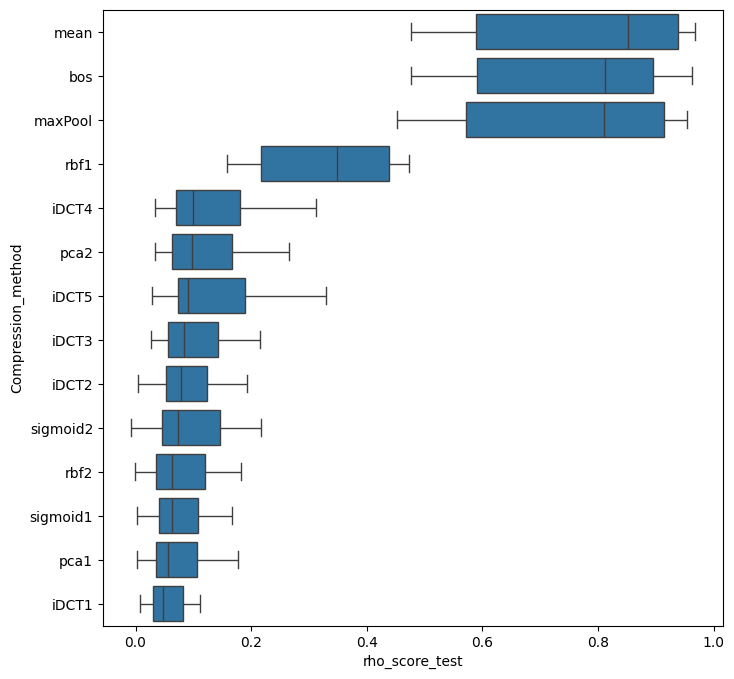

In [3]:
median_rho = data.groupby('Compression_method')['rho_score_test'].median().sort_values(ascending=False)

sorted_methods = median_rho.index

plt.figure(figsize=(8, 8))
sns.boxplot(data=data, y='Compression_method', x='rho_score_test', order=sorted_methods)
plt.show()

## Merging files

In [4]:
res = pd.read_csv('results_old/lassoCV_DMS/summary_all_DMS_results_LassoCV.csv')
res

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd,param,Unnamed: 0
0,CALM1 HUMAN,Lasso,1,0.128583,0.264203,0.331784,0.033199,0.284629,0.359028,0.369641,0.156957,66,pca2,150M,NaN
1,CALM1 HUMAN,Lasso,2,0.103640,0.262550,0.329823,0.012337,0.304502,0.386814,0.315175,0.155124,40,pca2,150M,NaN
2,CALM1 HUMAN,Lasso,3,0.212387,0.254364,0.321065,0.001540,0.268399,0.337534,0.462055,0.155688,123,pca2,150M,NaN
3,CALM1 HUMAN,Lasso,4,0.111624,0.272980,0.341273,0.030932,0.268016,0.331781,0.352709,0.142785,57,pca2,150M,NaN
4,CALM1 HUMAN,Lasso,5,0.080695,0.275670,0.344103,0.055682,0.269536,0.341199,0.308942,0.248996,32,pca2,150M,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4270,RL401 2013,Lasso,1,0.050742,0.263204,0.321773,-0.008374,0.298650,0.376428,0.235391,0.131002,20,iDCT4,15B,0.0
4271,RL401 2013,Lasso,2,0.016258,0.282718,0.339580,0.008364,0.272772,0.331500,0.168429,0.119068,10,iDCT4,15B,1.0
4272,RL401 2013,Lasso,3,0.177316,0.258746,0.315290,-0.003597,0.260892,0.308459,0.410647,0.160837,68,iDCT4,15B,2.0
4273,RL401 2013,Lasso,4,0.036510,0.278890,0.337751,-0.002890,0.272619,0.326152,0.177244,0.028667,15,iDCT4,15B,3.0


In [5]:
old_names = ['HG_FLU_Bloom2016', 'BLAT_ECOLX_Ostermeier2014',
       'RL401_YEAST_Bolon2014', 'PABP_YEAST_Fields2013_doubles',
       'B3VI55_LIPST_Whitehead2015', 'TIM_THETH', 'CALM1_HUMAN_Roth2017',
       'parEparD_Laub2015_all', 'BF520_env_Bloom2018',
       'UBC9_HUMAN_Roth2017', 'DLG4_RAT_Ranganathan2012',
       'BRCA1_HUMAN_RING', 'TPMT_HUMAN_Fowler2018',
       'MTH3_HAEAESTABILIZED_Tawfik2015', 'HSP82_YEAST_Bolon2016',
       'MK01_HUMAN_Johannessen', 'PTEN_HUMAN_Fowler2018',
       'BG505_env_Bloom2018', 'BLAT_ECOLX_Tenaillon2013', 'TIM_SULSO',
       'B3VI55_LIPSTSTABLE', 'RL401_YEAST_Bolon2013',
       'PABP_YEAST_Fields2013_singles', 'BLAT_ECOLX_Ranganathan2015',
       'RL401_YEAST_Fraser2016', 'TIM_THEMA', 'AMIE_PSEAE_Whitehead',
       'BG_STRSQ_hmmerbit', 'GAL4_YEAST_Shendure2015',
       'BLAT_ECOLX_Palzkill2012', 'SUMO1_HUMAN_Roth2017',
       'RASH_HUMAN_Kuriyan', 'YAP1_HUMAN_Fields2012_singles',
       'KKA2_KLEPN_Mikkelsen2014', 'TPK1_HUMAN_Roth2017',
       'PA_FLU_Sun2015', 'IF1_ECOLI',
       'UBE4B_MOUSE_Klevit2013_singles', 'HIS7_YEAST_Kondrashov2017', 'POLG_HCVJF_Sun2014', 'BRCA1_HUMAN_BRCT']

new_names = ['HG FLU', 'BLAT ECOLX 2014', 'RL401 2014',
       'PABP doubles', 'B3VI55 LIPST',
       'TIM THETH', 'CALM1 HUMAN', 'parEparD all',
       'BF520 env', 'UBC9 HUMAN', 'DLG4 RAT',
       'BRCA1 RING', 'TPMT HUMAN',
       'MTH3 HAEAESTABILIZED', 'HSP82 YEAST',
       'MK01 HUMAN', 'PTEN HUMAN',
       'BG505 env', 'BLAT ECOLX 2013', 'TIM SULSO',
       'B3VI55 LIPSTSTABLE', 'RL401 2013',
       'PABP singles', 'BLAT ECOLX 2015',
       'RL401 2016', 'TIM THEMA', 'AMIE PSEAE',
       'BG STRSQ', 'GAL4 YEAST',
       'BLAT ECOLX 2012', 'SUMO1 HUMAN',
       'RASH HUMAN', 'YAP1 singles',
       'KKA2 KLEPN', 'TPK1 HUMAN',
       'PA FLU', 'IF1 ECOLI',
       'UBE4B MOUSE', 'HIS7 YEAST', 'POLG HCVJF', 'BRCA1 HUMAN']



name_map = dict(zip(old_names, new_names))

In [8]:
dict_len = {}
dir = 'embeddings/DMS/'
for file in os.listdir(dir):
    if file.endswith('_esm2_150M'):
        file_name = file.split('_esm2_150M')[0]
        l = len(os.listdir(f'{dir}/{file}'))
        dict_len[name_map[file_name]] = l

df = pd.DataFrame.from_dict(dict_len, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)
df

,Dataset,length
0,YAP1 singles,362
1,BRCA1 RING,660
2,UBE4B MOUSE,899
3,BLAT ECOLX 2013,989
4,PABP singles,1187
5,GAL4 YEAST,1195
6,RL401 2013,1269
7,RL401 2016,1324
8,RL401 2014,1435
9,IF1 ECOLI,1439


In [9]:
res['datse_size'] = res.apply(lambda row: dict_len[row['Dataset']], axis=1)
res.drop(columns='Unnamed: 0', inplace=True)
res

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd,param,datse_size
0,CALM1 HUMAN,Lasso,1,0.128583,0.264203,0.331784,0.033199,0.284629,0.359028,0.369641,0.156957,66,pca2,150M,1962
1,CALM1 HUMAN,Lasso,2,0.103640,0.262550,0.329823,0.012337,0.304502,0.386814,0.315175,0.155124,40,pca2,150M,1962
2,CALM1 HUMAN,Lasso,3,0.212387,0.254364,0.321065,0.001540,0.268399,0.337534,0.462055,0.155688,123,pca2,150M,1962
3,CALM1 HUMAN,Lasso,4,0.111624,0.272980,0.341273,0.030932,0.268016,0.331781,0.352709,0.142785,57,pca2,150M,1962
4,CALM1 HUMAN,Lasso,5,0.080695,0.275670,0.344103,0.055682,0.269536,0.341199,0.308942,0.248996,32,pca2,150M,1962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4270,RL401 2013,Lasso,1,0.050742,0.263204,0.321773,-0.008374,0.298650,0.376428,0.235391,0.131002,20,iDCT4,15B,1269
4271,RL401 2013,Lasso,2,0.016258,0.282718,0.339580,0.008364,0.272772,0.331500,0.168429,0.119068,10,iDCT4,15B,1269
4272,RL401 2013,Lasso,3,0.177316,0.258746,0.315290,-0.003597,0.260892,0.308459,0.410647,0.160837,68,iDCT4,15B,1269
4273,RL401 2013,Lasso,4,0.036510,0.278890,0.337751,-0.002890,0.272619,0.326152,0.177244,0.028667,15,iDCT4,15B,1269


In [10]:
dts = res.query("param == '15B'")['Dataset'].unique()

In [11]:
res.query("param == '150M'")['Dataset'].unique()

array(['CALM1 HUMAN', 'YAP1 singles', 'TIM SULSO', 'MTH3 HAEAESTABILIZED',
       'KKA2 KLEPN', 'PA FLU', 'TIM THEMA', 'RL401 2016', 'IF1 ECOLI',
       'TPK1 HUMAN', 'B3VI55 LIPST', 'RL401 2013', 'BLAT ECOLX 2012',
       'GAL4 YEAST', 'PABP singles', 'TPMT HUMAN', 'BLAT ECOLX 2014',
       'HSP82 YEAST', 'B3VI55 LIPSTSTABLE', 'DLG4 RAT', 'AMIE PSEAE',
       'PTEN HUMAN', 'MK01 HUMAN', 'BRCA1 RING', 'BLAT ECOLX 2013',
       'TIM THETH', 'UBC9 HUMAN', 'BF520 env', 'parEparD all',
       'RASH HUMAN', 'BG STRSQ', 'PABP doubles', 'BLAT ECOLX 2015',
       'SUMO1 HUMAN', 'RL401 2014', 'HG FLU', 'BG505 env'], dtype=object)

In [12]:
res.query("param == '15B'")['Dataset'].unique()

array(['BLAT ECOLX 2015', 'PABP doubles', 'TIM THETH', 'PABP singles',
       'RL401 2014', 'DLG4 RAT', 'HSP82 YEAST', 'IF1 ECOLI', 'RASH HUMAN',
       'RL401 2013'], dtype=object)

In [13]:
res[(res.Dataset.isin(dts)) & (res.Compression_methd == 'mean')].query("param == '150M'")['Dataset'].unique()

array(['IF1 ECOLI', 'RL401 2013', 'PABP singles', 'HSP82 YEAST',
       'DLG4 RAT', 'TIM THETH', 'RASH HUMAN', 'PABP doubles',
       'BLAT ECOLX 2015', 'RL401 2014'], dtype=object)

In [14]:
res = res.query("(Dataset in @dts) & (Compression_methd == 'mean')")
res

,Dataset,Model,Fold,R2_score_train,MAE_score_train,RMSE_score_train,R2_score_test,MAE_score_test,RMSE_score_test,rho_score_train,rho_score_test,nun_zero_coefs,Compression_methd,param,datse_size
620,IF1 ECOLI,Lasso,1,0.691961,0.115100,0.158294,0.534048,0.133347,0.181835,0.678170,0.634494,113,mean,150M,1439
621,IF1 ECOLI,Lasso,2,0.406860,0.154618,0.216230,0.399972,0.159584,0.220855,0.560415,0.570122,28,mean,150M,1439
622,IF1 ECOLI,Lasso,3,0.406883,0.150753,0.212198,0.433335,0.158811,0.228425,0.564964,0.591413,33,mean,150M,1439
623,IF1 ECOLI,Lasso,4,0.547453,0.136613,0.191294,0.372707,0.150323,0.214201,0.607309,0.573936,54,mean,150M,1439
624,IF1 ECOLI,Lasso,5,0.606030,0.127437,0.177078,0.590060,0.129453,0.178995,0.647521,0.581756,75,mean,150M,1439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230,RL401 2013,Lasso,1,0.283095,0.222794,0.279633,0.006616,0.290972,0.373619,0.498452,0.244991,95,mean,15B,1269
4231,RL401 2013,Lasso,2,0.257283,0.237312,0.295062,0.099404,0.250051,0.315917,0.501313,0.337026,101,mean,15B,1269
4232,RL401 2013,Lasso,3,0.257493,0.241082,0.299533,0.078774,0.245385,0.295529,0.484934,0.325561,88,mean,15B,1269
4233,RL401 2013,Lasso,4,0.155268,0.255879,0.316251,0.044983,0.262183,0.318272,0.397306,0.239761,57,mean,15B,1269


In [15]:
print(res.query("param == '150M'")['R2_score_test'].corr(res.query("param == '150M'")['datse_size']))
print(res.query("param == '650M'")['R2_score_test'].corr(res.query("param == '650M'")['datse_size']))
print(res.query("param == '15B'")['R2_score_test'].corr(res.query("param == '15B'")['datse_size']))


0.6911236123676873
0.5954818854770169
0.5211845479475493


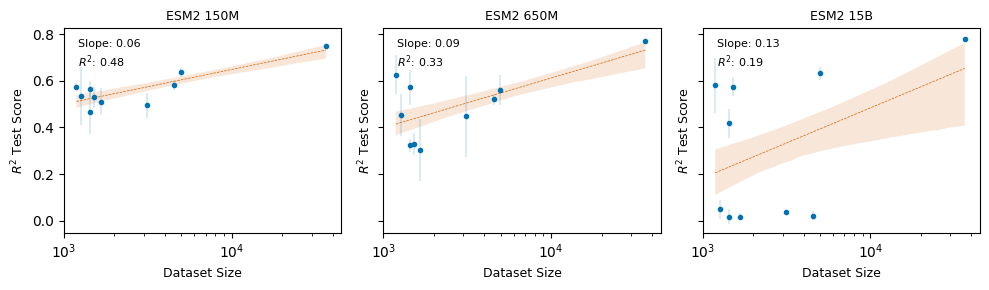

In [17]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


#Prepare the data
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for ax, ms in zip(axes, ['150M', '650M', '15B']):
    data = res.query(f"param == '{ms}'")

    # Prepare data (assumes your 'data' is a pandas DataFrame)
    X = np.log(data['datse_size'].values).reshape(-1, 1)  # Log-transform the x-values
    y = data['R2_score_test'].values

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficients
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict the values and calculate R²
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    
    # Calculate mean and standard deviation for each dataset size
    grouped_data = data.groupby('datse_size')['R2_score_test'].agg(['mean', 'std']).reset_index()
    
    # Calculate the correlation
    correlation = data['R2_score_test'].corr(data['datse_size'])
    
    # Scatter plot with error bars
    ax.errorbar(grouped_data['datse_size'], grouped_data['mean'], yerr=grouped_data['std'], fmt='o', markersize=3, color='#0072B2', ecolor='#0072B2', elinewidth=0.2, capsize=0)
    
    # Regression line
    sns.regplot(data=data, x='datse_size', y='R2_score_test', scatter=False, logx=True, color='#D55E00', line_kws={'linestyle': '--', 'linewidth': 0.5}, ax=ax)
    
    # Annotate the correlation coefficient
    #ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.95, f'Slope: {slope:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    ax.text(0.05, 0.88, f'$R^2$: {r2:.2f}', transform=ax.transAxes, fontsize=8, verticalalignment='top')
    
    # Set titles and labels
    ax.set_title(f'ESM2 {ms}', fontsize=9)
    ax.set_xlabel('Dataset Size', fontsize=9)
    ax.set_ylabel(r'$R^2$ Test Score', fontsize=9)
    ax.set_xlim(1000, 45000)
    ax.set_xscale('log')

plt.tight_layout()
#plt.savefig('results/lassoCV_DMS/summary_all_DMS_results_LassoCV_r2_sloop.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#res.to_csv('results/lassoCV_DMS/summary_all_DMS_results_LassoCV_mean.csv')